In [37]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine, utils
import torchinfo

In [38]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
data_path = Path("data/")
image_path = data_path / "soil_images_sorted"

In [40]:
# Get a set of pretrained model weights
weights = torchvision.models.VGG16_BN_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [41]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [42]:
#HyperParameters
batch_Size = 5
learning_rate = 0.0001
epochS = 20
dropout_prob = 0.5

In [43]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x238554ff170>,
 ['high', 'low', 'medium'])

In [44]:
model = torchvision.models.vgg16_bn(weights=weights).to(device)

In [45]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.features.parameters():
#     param.requires_grad = False

In [46]:
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"Frozen layer: {name}")

In [47]:
# Check if any parameter in model.features will compute gradients
any_grad_computation = not any(param.requires_grad for param in model.features.parameters())
any_grad_computation

False

In [48]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=25088, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [49]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [50]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:25<08:06, 25.63s/it]

Epoch: 1 | train_loss: 0.8873 | train_acc: 0.5588 | test_loss: 0.6170 | test_acc: 0.7667


 10%|█         | 2/20 [00:50<07:30, 25.03s/it]

Epoch: 2 | train_loss: 0.3585 | train_acc: 0.8794 | test_loss: 0.2896 | test_acc: 0.8667


 15%|█▌        | 3/20 [01:16<07:12, 25.44s/it]

Epoch: 3 | train_loss: 0.1447 | train_acc: 0.9471 | test_loss: 0.3863 | test_acc: 0.8222


 20%|██        | 4/20 [01:41<06:44, 25.28s/it]

Epoch: 4 | train_loss: 0.0892 | train_acc: 0.9853 | test_loss: 0.2188 | test_acc: 0.9000


 25%|██▌       | 5/20 [02:06<06:16, 25.11s/it]

Epoch: 5 | train_loss: 0.0646 | train_acc: 0.9912 | test_loss: 0.2740 | test_acc: 0.8778


 30%|███       | 6/20 [02:30<05:49, 24.95s/it]

Epoch: 6 | train_loss: 0.0491 | train_acc: 0.9882 | test_loss: 0.2723 | test_acc: 0.8556


 35%|███▌      | 7/20 [02:55<05:23, 24.92s/it]

Epoch: 7 | train_loss: 0.0164 | train_acc: 1.0000 | test_loss: 0.2181 | test_acc: 0.9000


 40%|████      | 8/20 [03:20<04:58, 24.91s/it]

Epoch: 8 | train_loss: 0.0562 | train_acc: 0.9824 | test_loss: 0.1753 | test_acc: 0.9333


 45%|████▌     | 9/20 [03:45<04:33, 24.90s/it]

Epoch: 9 | train_loss: 0.0904 | train_acc: 0.9735 | test_loss: 0.2114 | test_acc: 0.8889


 50%|█████     | 10/20 [04:10<04:09, 24.99s/it]

Epoch: 10 | train_loss: 0.0674 | train_acc: 0.9824 | test_loss: 0.3964 | test_acc: 0.8444


 55%|█████▌    | 11/20 [04:35<03:45, 25.05s/it]

Epoch: 11 | train_loss: 0.0358 | train_acc: 0.9941 | test_loss: 0.3139 | test_acc: 0.8222


 60%|██████    | 12/20 [05:00<03:18, 24.87s/it]

Epoch: 12 | train_loss: 0.0227 | train_acc: 0.9971 | test_loss: 0.2915 | test_acc: 0.9111


 65%|██████▌   | 13/20 [05:24<02:54, 24.87s/it]

Epoch: 13 | train_loss: 0.0237 | train_acc: 0.9971 | test_loss: 0.1900 | test_acc: 0.9333


 70%|███████   | 14/20 [05:49<02:28, 24.83s/it]

Epoch: 14 | train_loss: 0.0201 | train_acc: 1.0000 | test_loss: 0.1787 | test_acc: 0.9111


 75%|███████▌  | 15/20 [06:14<02:03, 24.80s/it]

Epoch: 15 | train_loss: 0.0190 | train_acc: 0.9971 | test_loss: 0.3187 | test_acc: 0.8667


 80%|████████  | 16/20 [06:39<01:38, 24.75s/it]

Epoch: 16 | train_loss: 0.0109 | train_acc: 1.0000 | test_loss: 0.2523 | test_acc: 0.8778


 85%|████████▌ | 17/20 [07:03<01:14, 24.76s/it]

Epoch: 17 | train_loss: 0.0483 | train_acc: 0.9853 | test_loss: 0.1909 | test_acc: 0.9222


 90%|█████████ | 18/20 [07:28<00:49, 24.59s/it]

Epoch: 18 | train_loss: 0.0440 | train_acc: 0.9941 | test_loss: 0.5113 | test_acc: 0.8111


 95%|█████████▌| 19/20 [07:52<00:24, 24.50s/it]

Epoch: 19 | train_loss: 0.0745 | train_acc: 0.9794 | test_loss: 0.5153 | test_acc: 0.8333


100%|██████████| 20/20 [08:16<00:00, 24.81s/it]

Epoch: 20 | train_loss: 0.0858 | train_acc: 0.9735 | test_loss: 0.5748 | test_acc: 0.8222
[INFO] Total training time: 496.156 seconds


In [51]:
utils.write_result_csv("../model_results_csvs/vggresults.csv",
                       batch_Size,
                       learning_rate,
                       epochS,
                       dropout_prob,
                       any_grad_computation,
                    #results
                        results["train_loss"],
                        results["train_acc"],
                        results["test_loss"],
                        results["test_acc"])

Inserted new data in ../model_results_csvs/vggresults.csv


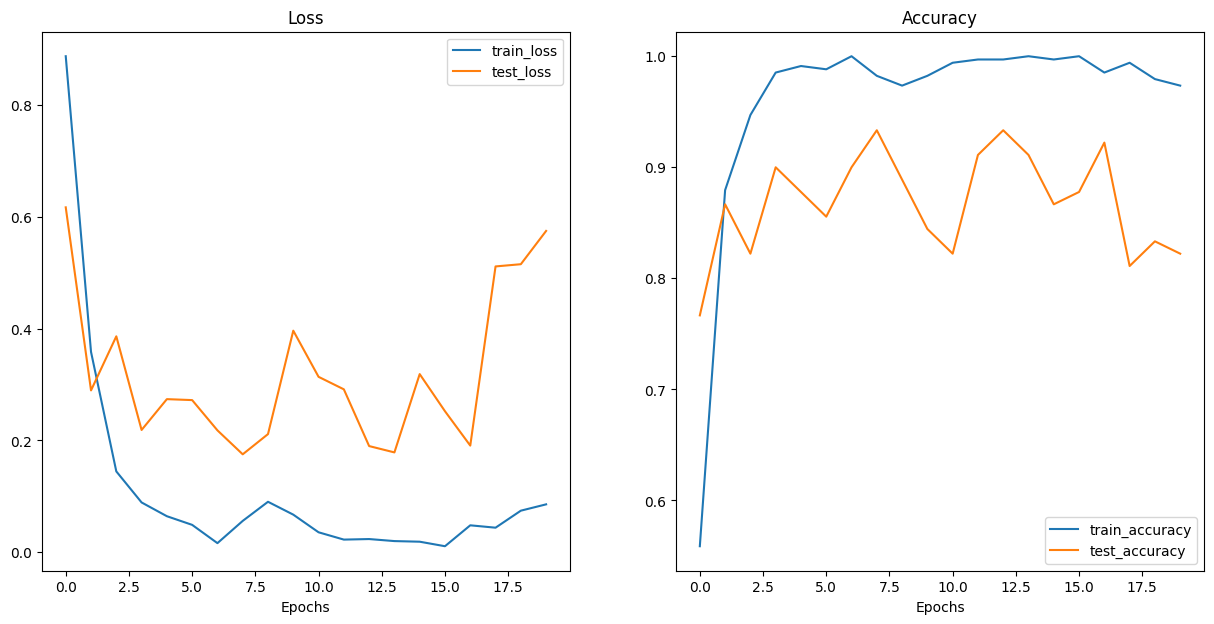

In [52]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

In [53]:
from winsound import Beep
Beep(300, 800)

In [54]:
utils.save_model(model=model,
                 target_dir="models",
                 model_name="vgg16_1.pth")

[INFO] Saving model to: models\vgg16_1.pth
